## Training

In [1]:
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense, Input, Add, merge, concatenate
from keras.layers.convolutional import Conv3D
from keras.layers.pooling import MaxPooling3D, GlobalAveragePooling3D, AveragePooling3D
from keras import metrics
from keras import optimizers
from keras.utils import plot_model
from keras import backend as K
from keras.utils.training_utils import multi_gpu_model
from keras.utils.data_utils import Sequence
from keras.callbacks import ModelCheckpoint
from keras.initializers import he_uniform
from keras.initializers import glorot_uniform

import numpy as np
import sys
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("models/")
sys.path.append("scripts/")

/usr/local/anaconda3/envs/deeplearning/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0, 1, 2, 3"

In [3]:
# Load the data
h5f = h5py.File('data/data_distributed2.h5', 'r')
train_x, train_y = h5f['train_x'][:], h5f['train_y'][:]
valid_x, valid_y = h5f['valid_x'][:], h5f['valid_y'][:]
test_x, test_y = h5f['test_x'][:], h5f['test_y'][:]
h5f.close()

print(train_x.shape, valid_x.shape, test_x.shape)

(3012, 24, 24, 24, 16) (377, 24, 24, 24, 16) (376, 24, 24, 24, 16)


In [4]:
from models import Squeeze_model

In [7]:
# from IPython.display import SVG
# from keras.utils.vis_utils import plot_model, model_to_dot
# model_input = Input(shape=(24, 24, 24, 16))
# squeeze_model = Model(inputs=model_input, outputs=Squeeze_model(model_input))
# plot_model(squeeze_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# SVG(model_to_dot(squeeze_model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))
# # plot_model(get_model4((24, 24, 24, 16)))

In [8]:
# Training parameters
nb_gpus = 4
nb_batch = nb_gpus*3
nb_epochs =100
l_rate = 1e-5

In [9]:
# checkpoint
outputFolder = './weights'
# if not os.path.exists(outputFolder):
#     os.makedirs(outputFolder)

filepath=outputFolder+"/weights-distributed_rotated_random_32.h5"

callbacks_list = [ModelCheckpoint(filepath, 
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=True,
                                  mode='auto', period=1)]

In [10]:
model_input = Input(shape=(28, 28, 28, 16))
squeeze_model = Model(inputs=model_input, outputs=Squeeze_model(model_input))
model = multi_gpu_model(squeeze_model, gpus=nb_gpus)

model.compile(optimizer=optimizers.adam(lr=l_rate),# beta_1=0.99, beta_2=0.999),
              loss='mean_absolute_error')

In [11]:
from my_classes import AugmentedDataGeneratorRandom

In [12]:
rotation_count = 32
aug_data_gen = AugmentedDataGeneratorRandom(x=train_x, y=train_y, batch_size=nb_batch, rotation_count=rotation_count)
aug_val_gen = AugmentedDataGeneratorRandom(x=valid_x, y=valid_y, batch_size=nb_batch, rotation_count=rotation_count)

In [13]:
for x, y in aug_data_gen:
    print(x.shape, y.shape)
    break

(396, 28, 28, 28, 16) (396,)


In [24]:
history = model.fit_generator(generator=aug_data_gen, validation_data=aug_val_gen,
                              use_multiprocessing=False, 
                              epochs=nb_epochs, 
                              max_queue_size=5, 
                              workers=56, 
                              verbose=1, callbacks=callbacks_list)

Epoch 1/100
251/251 [==============================] - 378s 2s/step - loss: 1.4068 - val_loss: 1.3170

Epoch 00001: val_loss did not improve
Epoch 2/100
251/251 [==============================] - 398s 2s/step - loss: 1.3831 - val_loss: 1.3720

Epoch 00002: val_loss did not improve
Epoch 3/100
251/251 [==============================] - 378s 2s/step - loss: 1.3853 - val_loss: 1.4306

Epoch 00003: val_loss did not improve
Epoch 4/100
251/251 [==============================] - 376s 1s/step - loss: 1.3726 - val_loss: 1.3313

Epoch 00004: val_loss did not improve
Epoch 5/100
251/251 [==============================] - 360s 1s/step - loss: 1.4097 - val_loss: 1.3688

Epoch 00005: val_loss did not improve
Epoch 6/100
251/251 [==============================] - 360s 1s/step - loss: 1.3936 - val_loss: 1.3756

Epoch 00006: val_loss did not improve
Epoch 7/100
251/251 [==============================] - 355s 1s/step - loss: 1.3865 - val_loss: 1.3106

Epoch 00007: val_loss did not improve
Epoch 8/100
2

251/251 [==============================] - 350s 1s/step - loss: 1.3577 - val_loss: 1.3834

Epoch 00057: val_loss did not improve
Epoch 58/100
251/251 [==============================] - 363s 1s/step - loss: 1.3456 - val_loss: 1.2025

Epoch 00058: val_loss improved from 1.21958 to 1.20254, saving model to ./weights/weights-distributed_rotated_random_32.h5
Epoch 59/100
251/251 [==============================] - 348s 1s/step - loss: 1.3388 - val_loss: 1.2510

Epoch 00059: val_loss did not improve
Epoch 60/100
251/251 [==============================] - 349s 1s/step - loss: 1.3613 - val_loss: 1.2887

Epoch 00060: val_loss did not improve
Epoch 61/100
251/251 [==============================] - 356s 1s/step - loss: 1.3760 - val_loss: 1.3072

Epoch 00061: val_loss did not improve
Epoch 62/100
251/251 [==============================] - 361s 1s/step - loss: 1.3385 - val_loss: 1.2913

Epoch 00062: val_loss did not improve
Epoch 63/100
251/251 [==============================] - 357s 1s/step - loss:

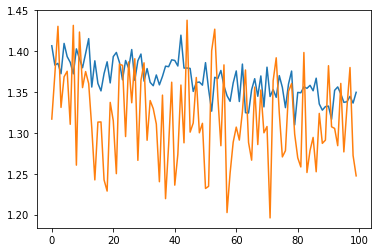

In [40]:
# First 100 epochs
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [41]:
# Save the history
import pickle

with open(os.path.join(outputFolder, "history_distributed_rotated_random_32_2.pickle"), 'wb') as f:
    pickle.dump(history.history, f)

In [42]:
from sklearn.metrics import r2_score

In [43]:
model.load_weights(filepath)

In [44]:
rotation_count = 32
sample_size = 200

In [45]:
train_aug_data_gen = AugmentedDataGeneratorRandom(x=train_x[:sample_size],
                                            y=train_y[:sample_size],
                                            batch_size=sample_size,
                                            rotation_count=rotation_count)

test_aug_data_gen = AugmentedDataGeneratorRandom(x=test_x[:sample_size],
                                            y=test_y[:sample_size],
                                            batch_size=sample_size,
                                            rotation_count=rotation_count)

In [46]:
# Train r2

for x, y in train_aug_data_gen:
    # Without average
    train_r2 = r2_score(y_true=y, y_pred=model.predict(x))
    print("Train r2 (without average): ", train_r2)
    
    # With average
    y_pred = model.predict(x)[:, 0]
    
    sample_y = np.zeros(sample_size)
    sample_ypred = np.zeros(sample_size)
    for i in range(sample_size):
        start = i*(rotation_count+1)
        end = i*(rotation_count+1) + (rotation_count+1)
        mean_ypred = np.mean(y_pred[start:end])
        mean_y = np.mean(y[start:end])
        sample_ypred[i] = mean_ypred
        sample_y[i] = mean_y
    
    train_r2 = r2_score(y_true=sample_y, y_pred=sample_ypred)
    print("Train r2 (with average): ", train_r2)
    break

Train r2 (without average):  0.33640450074217176
Train r2 (with average):  0.34906221850963737


In [47]:
# Test r2

for x, y in test_aug_data_gen:
    # Without average
    test_r2 = r2_score(y_true=y, y_pred=model.predict(x))
    print("Test r2 (without average): ", test_r2)
    
    # With average
    y_pred = model.predict(x)[:, 0]
    
    sample_y = np.zeros(sample_size)
    sample_ypred = np.zeros(sample_size)
    for i in range(sample_size):
        start = i*(rotation_count+1)
        end = i*(rotation_count+1) + (rotation_count+1)
        mean_ypred = np.mean(y_pred[start:end])
        mean_y = np.mean(y[start:end])
        sample_ypred[i] = mean_ypred
        sample_y[i] = mean_y
    
    test_r2 = r2_score(y_true=sample_y, y_pred=sample_ypred)
    print("Test r2 (with average): ", test_r2)
    break

Test r2 (without average):  0.2717983069298848
Test r2 (with average):  0.29082336619746274
